<a href="https://colab.research.google.com/github/TilakSanghvi/Bitcoin_Price_Predictor_Using_Sentiments_And_LSTM/blob/main/Bitcoin_Price_Predictor_Using_Sentiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path

In [4]:
#Load the fear and greed sentiment data for Bitcoin
csv_path = Path("/content/btc_sentiment.csv")
df = pd.read_csv(csv_path, index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns="fng_classification")
df.head()

<ipython-input-4-127bdfeda659>:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(csv_path, index_col="date", infer_datetime_format=True, parse_dates=True)
<ipython-input-4-127bdfeda659>:3: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(csv_path, index_col="date", infer_datetime_format=True, parse_dates=True)


,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [5]:
csv_path2 = Path("/content/btc_historic.csv")
df2 = pd.read_csv(csv_path2, index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.tail()

<ipython-input-5-8198617fe1da>:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df2 = pd.read_csv(csv_path2, index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']


Date
2019-07-25    9882.429688
2019-07-26    9847.450195
2019-07-27    9478.320313
2019-07-28    9531.769531
2019-07-29    9529.889648
Name: Close, dtype: float64

In [6]:
df = df.join(df2, how="inner")
df.tail()

,fng_value,Close
date,,
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [7]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [8]:
window_size = 7

feature_column = 1
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

In [9]:
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [10]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)
len(X_test)

161

In [11]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [13]:
model = Sequential()

number_units = 30
dropout_fraction = 0.3

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [14]:
model.compile(optimizer="adam", loss="mean_squared_error")

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 30)             3840      
                                                                 
 dropout (Dropout)           (None, 7, 30)             0         
                                                                 
 lstm_1 (LSTM)               (None, 7, 30)             7320      
                                                                 
 dropout_1 (Dropout)         (None, 7, 30)             0         
                                                                 
 lstm_2 (LSTM)               (None, 30)                7320      
                                                                 
 dropout_2 (Dropout)         (None, 30)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

In [16]:
model.fit(X_train, y_train, epochs=15, shuffle=False, batch_size=2)

Epoch 1/15
187/187 [==============================] - 7s 9ms/step - loss: 0.0277
Epoch 2/15
187/187 [==============================] - 3s 16ms/step - loss: 0.0205
Epoch 3/15
187/187 [==============================] - 2s 13ms/step - loss: 0.0211
Epoch 4/15
187/187 [==============================] - 2s 10ms/step - loss: 0.0163
Epoch 5/15
187/187 [==============================] - 2s 10ms/step - loss: 0.0138
Epoch 6/15
187/187 [==============================] - 2s 10ms/step - loss: 0.0136
Epoch 7/15
187/187 [==============================] - 2s 10ms/step - loss: 0.0114
Epoch 8/15
187/187 [==============================] - 2s 12ms/step - loss: 0.0128
Epoch 9/15
187/187 [==============================] - 3s 16ms/step - loss: 0.0113
Epoch 10/15
187/187 [==============================] - 2s 9ms/step - loss: 0.0111
Epoch 11/15
187/187 [==============================] - 2s 9ms/step - loss: 0.0087
Epoch 12/15
187/187 [==============================] - 2s 9ms/step - loss: 0.0097
Epoch 13/15
187/1

In [17]:
model.evaluate(X_test, y_test)

6/6 [==============================] - 2s 5ms/step - loss: 0.0304


0.030399594455957413

In [18]:
predicted = model.predict(X_test)

6/6 [==============================] - 2s 8ms/step


In [20]:
#Recover the actual price from scalled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [21]:
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ])
stocks.head()

,Real,Predicted
date,,
2019-02-19,3912.570068,3700.951660
2019-02-20,3924.239990,3722.744873
2019-02-21,3974.050049,3759.134766
2019-02-22,3937.040039,3806.080078
2019-02-23,3983.530029,3853.001953


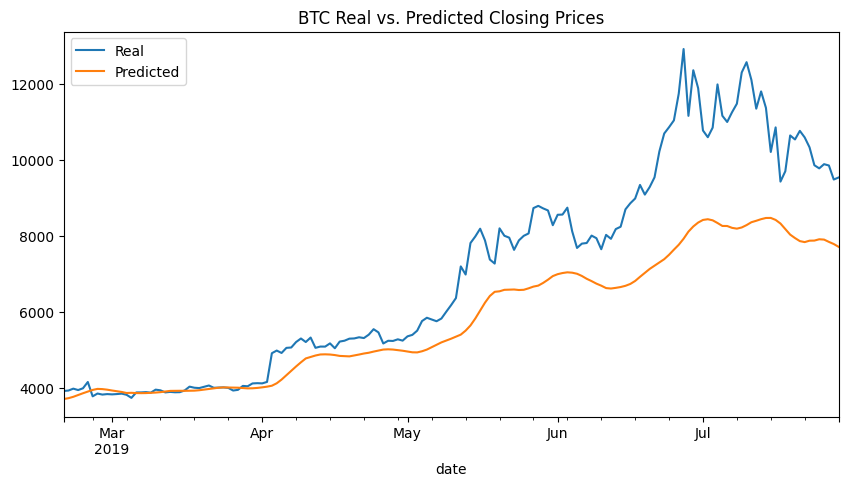

In [22]:
stocks.plot(title="BTC Real vs. Predicted Closing Prices", figsize=(10,5));